## Time Series Forecasting

### Data: Monthly Sales of French Champagne

The task is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France). The dataset provides the number of monthly sales of champagne (in millions) from January 1964 to September 1972, or just under 10 years of data. There are 105 observations.

Download the dataset as a CSV file and place it in your current working directory with the filename “champagne.csv“.

In [51]:
# Temporarily Suppressing Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from matplotlib import pyplot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# from statsmodels.tsa.stattools import adfuller # check if stationary

import pandas as pd
import numpy as np
from pandas import TimeGrouper

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA

# Temporarily Suppressing Warnings
# import warnings
# warnings.filterwarnings("ignore")

### Loading and analizing dataset

In [30]:
series = pd.read_csv('champagne.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
print(series.head())

1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Month,"Perrin Freres monthly champagne sales millions ?64-?72", dtype: object


In [31]:
series.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', length=105, freq=None)

In [32]:
series = series.astype('float32')

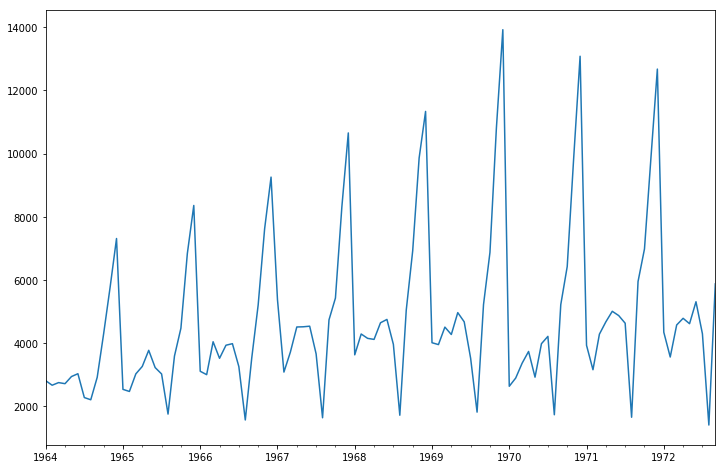

In [33]:
series.plot(figsize=(12,8))

In [34]:
series.describe()

count      105.000000
mean      4761.152344
std       2553.502686
min       1413.000000
25%       3113.000000
50%       4217.000000
75%       5221.000000
max      13916.000000
Name: Month,"Perrin Freres monthly champagne sales millions ?64-?72", dtype: float64

Some observations from these statistics include:

The number of observations (count) matches our expectation, meaning we are handling the data correctly. The mean is about 4,761, which we might consider our level in this series. The standard deviation (average spread from the mean) is relatively large at 2,553 sales. The percentiles along with the standard deviation do suggest a large spread to the data.

### Spliting dataset into train, valid and test


Let's the final 12 month of data will be used to test the final model.

In [35]:
split_point2 = len(series) - 12
split_point1 = round(split_point2*0.5)
train, valid, test = series[0:split_point1], series[split_point1:split_point2], series[split_point2:]
print('train %d, valid %d, test %d' % (len(train), len(valid), len(test)))

train 46, valid 47, test 12


Note The behavior of round() for floats can be surprising: for example, round(46.5) gives 46 instead of the expected 47. This is not a bug: it’s a result of the fact that most decimal fractions can’t be represented exactly as a float. See <a href="https://docs.python.org/2/tutorial/floatingpoint.html#tut-fp-issues">Floating Point Arithmetic: Issues and Limitations</a> for more information.

In [36]:
test

1971-10-01     6981.0
1971-11-01     9851.0
1971-12-01    12670.0
1972-01-01     4348.0
1972-02-01     3564.0
1972-03-01     4577.0
1972-04-01     4788.0
1972-05-01     4618.0
1972-06-01     5312.0
1972-07-01     4298.0
1972-08-01     1413.0
1972-09-01     5877.0
Name: Month,"Perrin Freres monthly champagne sales millions ?64-?72", dtype: float32

### Typical blocks

In [10]:
# # walk-forward prediction
# history = list(train.values)
# predictions = list()
# for i in range(len(valid)): # range(0, 47)
#     # predict
#     yhat = ...
#     predictions.append(yhat)
#     # observation
#     obs = valid.values[i]
#     history.append(obs)
#     print('Predicted=%.3f, Expected=%3.f' % (yhat, obs))

In [11]:
# # report performance
# mse = mean_squared_error(valid.values, predictions)
# rmse = sqrt(mse)
# print('RMSE: %.3f' % rmse)

### Baseline prediction: simple naive model

In [37]:
# walk-forward prediction
history = list(train.values)
predictions = list()
for i in range(len(valid)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = valid.values[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(valid.values, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

Predicted=5428.000, Expected=8314
Predicted=8314.000, Expected=10651
Predicted=10651.000, Expected=3633
Predicted=3633.000, Expected=4292
Predicted=4292.000, Expected=4154
Predicted=4154.000, Expected=4121
Predicted=4121.000, Expected=4647
Predicted=4647.000, Expected=4753
Predicted=4753.000, Expected=3965
Predicted=3965.000, Expected=1723
Predicted=1723.000, Expected=5048
Predicted=5048.000, Expected=6922
Predicted=6922.000, Expected=9858
Predicted=9858.000, Expected=11331
Predicted=11331.000, Expected=4016
Predicted=4016.000, Expected=3957
Predicted=3957.000, Expected=4510
Predicted=4510.000, Expected=4276
Predicted=4276.000, Expected=4968
Predicted=4968.000, Expected=4677
Predicted=4677.000, Expected=3523
Predicted=3523.000, Expected=1821
Predicted=1821.000, Expected=5222
Predicted=5222.000, Expected=6872
Predicted=6872.000, Expected=10803
Predicted=10803.000, Expected=13916
Predicted=13916.000, Expected=2639
Predicted=2639.000, Expected=2899
Predicted=2899.000, Expected=3370
Predic

Naive model achieved an RMSE of 3186.501. This means that on average, the model was wrong by about 3186 million sales for each prediction made.

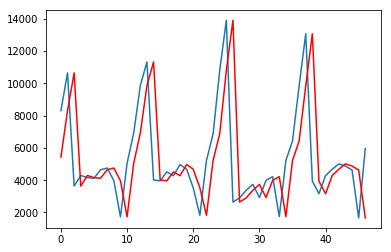

In [38]:
pyplot.plot(valid.values)
pyplot.plot(predictions, color='red')

In [39]:
# On analogy with simple naive model (RMSE, plot) build 3 other naive models

#### Naive with trend

#### Naive with seasonality

#### Naive with trend and seasonality

### ARIMA models

Create x as concatenated train and valid. 

In [40]:
x = train.append(valid)

#### 1. Check if x is stationary ( mean and variance don't change over time). If not, transform to a stationary one.
How to understand that the series is not stationary?
- In the values of the series there is an increase or a decline.
- Autocorrelation and Partial Autocorrelation plots demonstrate the absence of a rapid disappearance of coefficients.
- Check with Dickey-Fuller test.

The series plot shows a trend, that indicates the nonstationary nature of the series.

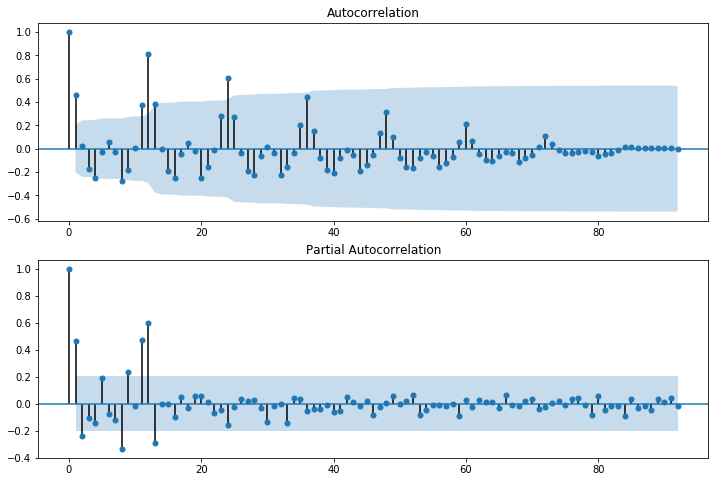

In [41]:
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211) # grid with 2 rows abd 1 column, the 1st subplot
fig = plot_acf(x, ax=ax1)
ax2 = fig.add_subplot(212) # grid with 2 rows abd 1 column, the 2nd subplot
fig = plot_pacf(x, ax=ax2)

Autocorrelation and Partial Autocorrelation plots demonstrate the absence of a rapid disappearance of coefficients. It prooves the nonstationary nature of the series.

<b>Transform x to a stationary one.</b>

In [42]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

Lag for difference is determined from the analysis of plots.

Series plot
- If there are strong level changes (strong jumps up or down), then take first-order differences.
- If there are strong changes in slope, then take second-order differences.
- If there is a seasonal component, then take the seasonal difference.

Autocorrelation plot
- If there is a slow decrease of autocorrelation coefficients, then take first-order differences.

In [43]:
months_in_year = 12
x_diff_12 = difference(x.values, months_in_year)
x_diff_12.index = x.index[months_in_year:]

In [44]:
x_diff_12.index[0]

Timestamp('1965-01-01 00:00:00')

In [45]:
x.index[0]

Timestamp('1964-01-01 00:00:00')

<b>Check, if x_diff_12 is a stationary one.</b>

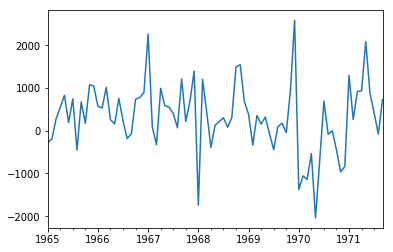

In [46]:
x_diff_12.plot()

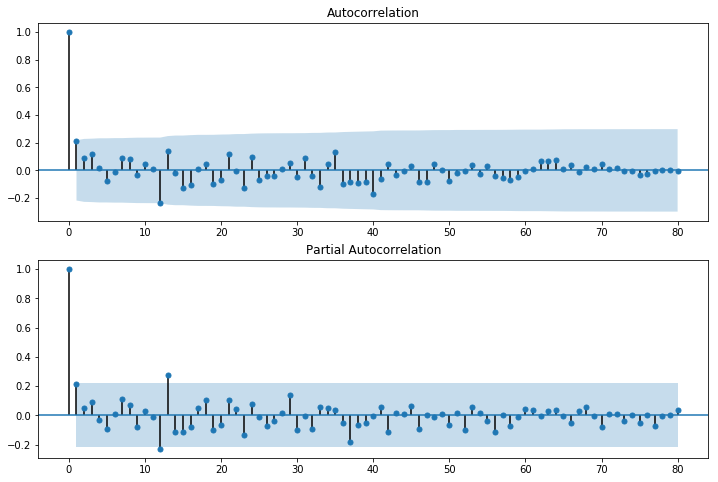

In [47]:
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211) # grid with 2 rows abd 1 column, the 1st subplot
fig = plot_acf(x_diff_12, ax=ax1)
ax2 = fig.add_subplot(212) # grid with 2 rows abd 1 column, the 2nd subplot
fig = plot_pacf(x_diff_12, ax=ax2)

In [23]:
# Dickey-Fuller test
# result = adfuller(x_diff_12)

In [24]:
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

Conclusion: x_diff_12 is a stationary one

#### 2. Determine p and q and build an ARIMA model

Comparing plots for x_diff_12 with theoretical values for different ARMA models, we chose p = 1, q = 1.

In [25]:
# Example of one step forward prediction

In [48]:
history = list(train.values)
diff = difference(history, months_in_year)
model = ARIMA(diff.values, order=(1,0,1))

In [49]:
model

In [52]:
model_fit = model.fit(trend='nc')
model_fit

In [22]:
yhat = model_fit.forecast()[0]
yhat

470.841069933071

In [23]:
# walk-forward prediction
history = list(train.values)
predictions = list()
months_in_year = 12
for i in range(len(valid)):
    # difference data
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff.values, order=(1,0,1))
    model_fit = model.fit(trend='nc')
    yhat = model_fit.forecast()[0]
    yhat = yhat + history[-months_in_year] # inverse_difference
    predictions.append(yhat)
    # observation
    obs = valid.values[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(valid.values, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

Predicted=8084.841, Expected=8314
Predicted=9735.477, Expected=10651
Predicted=5934.524, Expected=3633
Predicted=3569.759, Expected=4292
Predicted=4146.158, Expected=4154
Predicted=4961.778, Expected=4121
Predicted=4964.592, Expected=4647
Predicted=4963.527, Expected=4753
Predicted=4080.676, Expected=3965
Predicted=2056.284, Expected=1723
Predicted=5149.353, Expected=5048
Predicted=5831.547, Expected=6922
Predicted=8717.661, Expected=9858
Predicted=11078.165, Expected=11331
Predicted=4083.390, Expected=4016
Predicted=4747.462, Expected=3957


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [24]:
# walk-forward prediction
history = list(train.values)
predictions = list()
months_in_year = 12
for i in range(len(valid)):
    # difference data
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff.values, order=(1,1,1))
    model_fit = model.fit(trend='nc')
    yhat = model_fit.forecast()[0]
    yhat = yhat + history[-months_in_year] # inverse_difference
    predictions.append(yhat)
    # observation
    obs = valid.values[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(valid.values, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

Predicted=8089.841, Expected=8314
Predicted=9742.721, Expected=10651
Predicted=5986.916, Expected=3633
Predicted=3887.125, Expected=4292
Predicted=4038.130, Expected=4154
Predicted=4992.339, Expected=4121
Predicted=5156.501, Expected=4647
Predicted=5046.657, Expected=4753
Predicted=4143.732, Expected=3965
Predicted=2102.965, Expected=1723
Predicted=5228.296, Expected=5048
Predicted=5873.355, Expected=6922
Predicted=8571.313, Expected=9858
Predicted=11006.135, Expected=11331
Predicted=4087.485, Expected=4016
Predicted=4771.845, Expected=3957
Predicted=4676.093, Expected=4510
Predicted=4583.381, Expected=4276
Predicted=5117.345, Expected=4968
Predicted=5208.143, Expected=4677
Predicted=4436.418, Expected=3523
Predicted=2180.888, Expected=1821
Predicted=5471.214, Expected=5222
Predicted=7337.592, Expected=6872
Predicted=10268.406, Expected=10803
Predicted=11725.384, Expected=13916
Predicted=4519.419, Expected=2639
Predicted=4606.449, Expected=2899
Predicted=4938.693, Expected=3370
Predict

RMSE of 956.955, which is dramatically better than the naive RMSE of 3186.501.
This is a great start, but we may be able to get improved results with a better configured ARIMA model.

#### 3. Model verification via Residual Errors Review

3.1 The residuals should be random and small (a normally distributed random variable with zero mean). For verification, the histogram and probability density plot of residuals are constructed and their form is compared with the histogram and the probability density of the standard normal distribution.<br>
3.2 Partial Autocorrelation coefficients for residuals should be in the neighborhood of zero and within the zone [-0.2, 0.2].

In [25]:
# errors
residuals = [valid.values[i]-predictions[i] for i in range(len(valid))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

                 0
count    47.000000
mean   -104.248968
std     961.543863
min   -2353.915751
25%    -519.662532
50%    -178.732423
75%     364.869827
max    2190.615961


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A55B10AEB8>]],
      dtype=object)

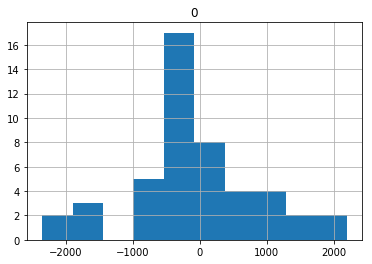

In [26]:
# plot
residuals.hist()

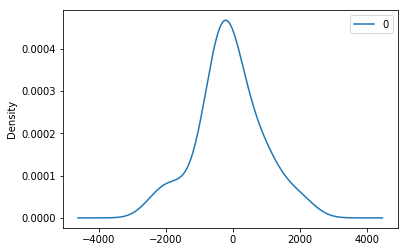

In [27]:
residuals.plot(kind='kde')

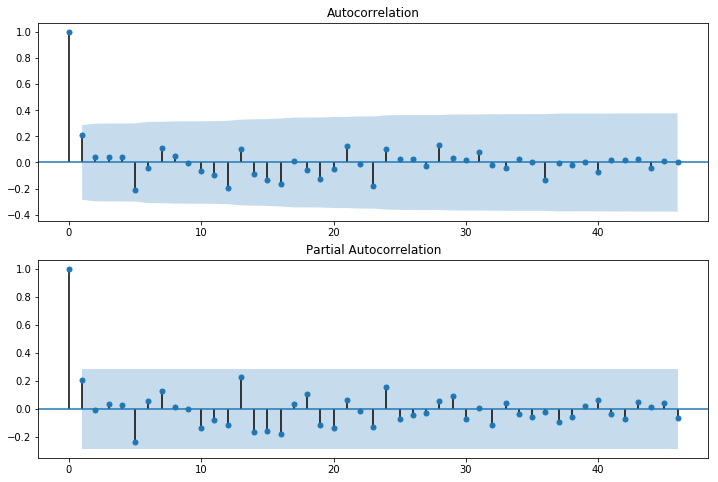

In [28]:
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211) # grid with 2 rows abd 1 column, the 1st subplot
fig = plot_acf(residuals, ax=ax1)
ax2 = fig.add_subplot(212) # grid with 2 rows abd 1 column, the 2nd subplot
fig = plot_pacf(residuals, ax=ax2)

Conclusion: We can see that the distribution has a left shift and that the mean is non-zero at -104.248968. This is perhaps a sign that the predictions are biased. We could use this information to bias-correct predictions by adding the mean residual error of -104.248968 to each forecast made. The example below performs this.

In [29]:
# walk-forward prediction
history = list(train.values)
predictions = list()
months_in_year = 12
bias = -104.248968
for i in range(len(valid)):
    # difference data
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff.values, order=(1,1,1))
    model_fit = model.fit(trend='nc')
    yhat = model_fit.forecast()[0]
    yhat = yhat + bias + history[-months_in_year] # inverse_difference
    predictions.append(yhat)
    # observation
    obs = valid.values[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(valid.values, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

Predicted=7985.592, Expected=8314
Predicted=9638.472, Expected=10651
Predicted=5882.667, Expected=3633
Predicted=3782.876, Expected=4292
Predicted=3933.881, Expected=4154
Predicted=4888.090, Expected=4121
Predicted=5052.252, Expected=4647
Predicted=4942.408, Expected=4753
Predicted=4039.483, Expected=3965
Predicted=1998.716, Expected=1723
Predicted=5124.047, Expected=5048
Predicted=5769.106, Expected=6922
Predicted=8467.064, Expected=9858
Predicted=10901.886, Expected=11331
Predicted=3983.236, Expected=4016
Predicted=4667.596, Expected=3957
Predicted=4571.844, Expected=4510
Predicted=4479.132, Expected=4276
Predicted=5013.096, Expected=4968
Predicted=5103.894, Expected=4677
Predicted=4332.169, Expected=3523
Predicted=2076.639, Expected=1821
Predicted=5366.965, Expected=5222
Predicted=7233.343, Expected=6872
Predicted=10164.157, Expected=10803
Predicted=11621.135, Expected=13916
Predicted=4415.170, Expected=2639
Predicted=4502.201, Expected=2899
Predicted=4834.444, Expected=3370
Predict

In [30]:
# errors
residuals = [valid.values[i]-predictions[i] for i in range(len(valid))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

                  0
count  4.700000e+01
mean  -2.897720e-07
std    9.615439e+02
min   -2.249667e+03
25%   -4.154136e+02
50%   -7.448346e+01
75%    4.691188e+02
max    2.294865e+03


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A55B45A550>]],
      dtype=object)

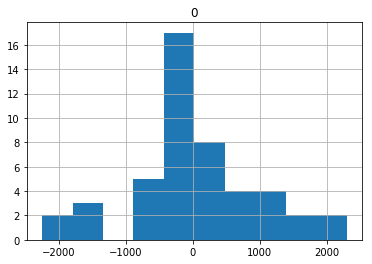

In [31]:
# plot
residuals.hist()

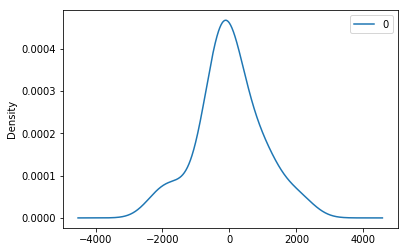

In [32]:
residuals.plot(kind='kde')

The performance of the predictions is improved very slightly from 956.955 to 951.260. The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero.

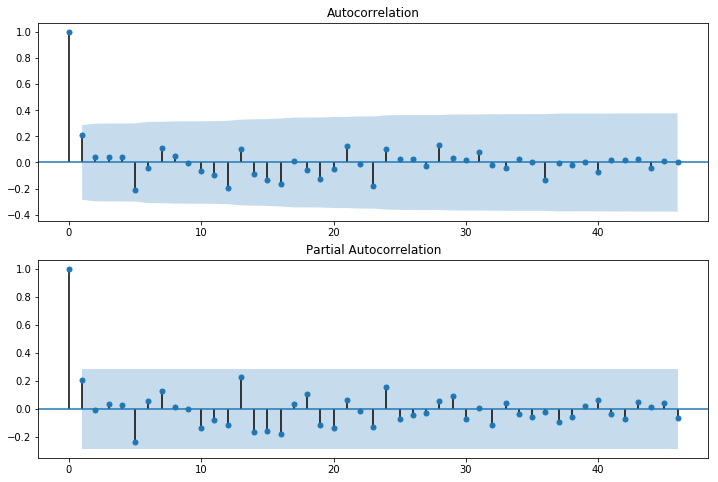

In [33]:
fig = pyplot.figure(figsize=(12,8))
ax1 = fig.add_subplot(211) # grid with 2 rows abd 1 column, the 1st subplot
fig = plot_acf(residuals, ax=ax1)
ax2 = fig.add_subplot(212) # grid with 2 rows abd 1 column, the 2nd subplot
fig = plot_pacf(residuals, ax=ax2)

Conclusion. Autocorrelation that is present in the time series, has been captured by the model. Now we can check model performance on test data.

### Check ARIMA model performance on test data

We'll train ARIMA model on concatenated train and valid dataset <i>x</i> and use the model to predict on <i>test</i> (“unseen” data - last 12 month).

In [34]:
# walk-forward prediction
history = list(x.values)
predictions = list()
months_in_year = 12
bias = -104.248968
for i in range(len(test)):
    # difference data
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff.values, order=(1,1,1))
    model_fit = model.fit(trend='nc')
    yhat = model_fit.forecast()[0]
    yhat = yhat + bias + history[-months_in_year] # inverse_difference
    predictions.append(yhat)
    # observation
    obs = test.values[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test.values, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

Predicted=6700.178, Expected=6981
Predicted=10090.331, Expected=9851
Predicted=13193.351, Expected=12670
Predicted=3938.769, Expected=4348
Predicted=3355.714, Expected=3564
Predicted=4482.484, Expected=4577
Predicted=4849.168, Expected=4788
Predicted=5139.441, Expected=4618
Predicted=4872.886, Expected=5312
Predicted=4821.827, Expected=4298
Predicted=1662.872, Expected=1413
Predicted=5957.868, Expected=5877
RMSE: 346.609


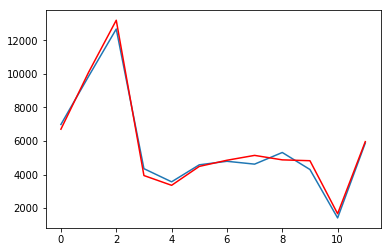

In [35]:
pyplot.plot(test.values)
pyplot.plot(predictions, color='red')

The final RMSE for the test period is predicted at 346.609 million sales. It's much better than the expectation of an error of a little more than 951 million sales per month. 

At this scale on the plot, the 12 months of forecast sales figures look fantastic.

### Grid Search ARIMA Hyperparameters

The ACF and PACF plots suggest that an ARIMA(1,0,1) or similar may be the best that we can do.

To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and check RMSE performance.

We will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance on the valid. We will use a grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters: p: 0 to 2; d: 0 to 2; q: 0 to 2.

In [36]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(train, valid, arima_order):
    history = list(train.values)
    predictions = list()
    months_in_year = 12
    
    for i in range(len(valid)):
        # difference data
        diff = difference(history, months_in_year)
        # predict
        model = ARIMA(diff.values, order=arima_order)
        model_fit = model.fit(trend='nc')
        yhat = model_fit.forecast()[0]
        yhat = yhat + history[-months_in_year] # inverse_difference
        predictions.append(yhat)
        history.append(valid.values[i])
    # calculate out of sample error
    mse = mean_squared_error(valid.values, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, valid, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, valid, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

evaluate_models(train, valid, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 0, 2) RMSE=962.289
ARIMA(0, 1, 1) RMSE=958.297


D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1) RMSE=1146.987
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.955


D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0) RMSE=1555.858
ARIMA(2, 0, 0) RMSE=955.134


D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0) RMSE=1030.467
ARIMA(2, 1, 1) RMSE=980.958


D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0) RMSE=1346.598


D:\Anaconda3\envs\py36\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1) RMSE=1039.618
Best ARIMA(0, 0, 1) RMSE=939.464


#### Best ARIMA verification via Residual Errors Review

#### Check best ARIMA performance on test data